# EPR Fluxonium Qubits

## Sections
1. Prepare the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on single mode. <br>
1. Get qubit freq and anharmonicity. <br>

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis

### Create the Qubit design

Setup a design of a given dimension. Dimensions will be respected in the design rendering. <br>
Note that the design size extends from the origin into the first quadrant.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.material = 'silicon'
design.chips.main.size['size_x'] = '9mm'
design.chips.main.size['size_y'] = '9mm'
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '8.733 um'

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

hfss = design.renderers.hfss
gui = MetalGUI(design)

In [9]:
from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket
# Q1 details
options = dict(chip='main', pad_gap='30um', orientation='0', nanowire = False, 
          pos_x = '-2.2mm', pos_y = '-2.3mm',     
            
    flux_bias_line_options=Dict(make_fbl = True,), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
            cl_length = '80um', cl_sep ='10um' ), 
    readout_line_options=Dict(loc_H = -1, make_rol = True, 
            pad_width = '350um', pad_height = '90um',
            pad_sep='65um'))
               
q1 = FluxoniumPocket(design,'Q1', options = dict(
        **options))

# Q2 details
options = dict(chip='main', pad_gap='30um', orientation='0', nanowire = False, 
          pos_x = '-1.2mm', pos_y = '-1.3mm',     
            
    flux_bias_line_options=Dict(make_fbl = True,), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
            cl_length = '80um', cl_sep ='10um' ), 
    readout_line_options=Dict(loc_H = -1, make_rol = True, 
            pad_width = '350um', pad_height = '90um',
            pad_sep='65um'))
               
q2 = FluxoniumPocket(design,'Q2', options = dict(
        **options))

gui.rebuild()

In [12]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-3.99mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='3.99mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '3970um', 'end_straight': '3970um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [5]:
renderer = gui.canvas.metal_renderer
renderer.styles['poly']['base']['linewidth'] = 1
#renderer.styles['poly']['base']['colors'] = 'r'
renderer.styles['poly']['base']['edgecolors'] ='g'
renderer.styles['poly']['base']['hatch'] = None
renderer.styles['poly']['non-subtracted']['hatch'] = '/'

renderer.styles['JJ']['base']['color']= 'red'
renderer.styles['JJ']['base']['alpha']= 0.3

gui.refresh_plot()

In [13]:
renderer.styles['JJ']['base']['color']= 'red'
gui.rebuild()

In [6]:
self = renderer
table =self.qgeometry.tables['poly']
for component in table.component.unique():
    tb = table[table.component == component]
#table.component == 2

In [8]:
q1

name:    Q1
class:   FluxoniumPocket       
options: 
  'pos_x'             : '-2.2mm',                     
  'pos_y'             : '-2.3mm',                     
  'orientation'       : '0',                          
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'connection_pads'   : {
                        },
  'pad_gap'           : '30um',                       
  'jj_width'          : '10um',                       
  'jj_orientation'    : '1',                          
  'pad_width'         : '15um',                       
  'pad_height'        : '100um',                      
  'pad_radius'        : '60um',                       
  'inductor_orientation': '-1',                         
  'l_width'           : '1um',                        
  'array_length'      : '130um',                      
  'l_arm_width'       : '2um',                        
  'l_arm_length'      : '20um',                       
  'l_induct

In [7]:
table.component

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     2
10    2
11    3
12    3
Name: component, dtype: object

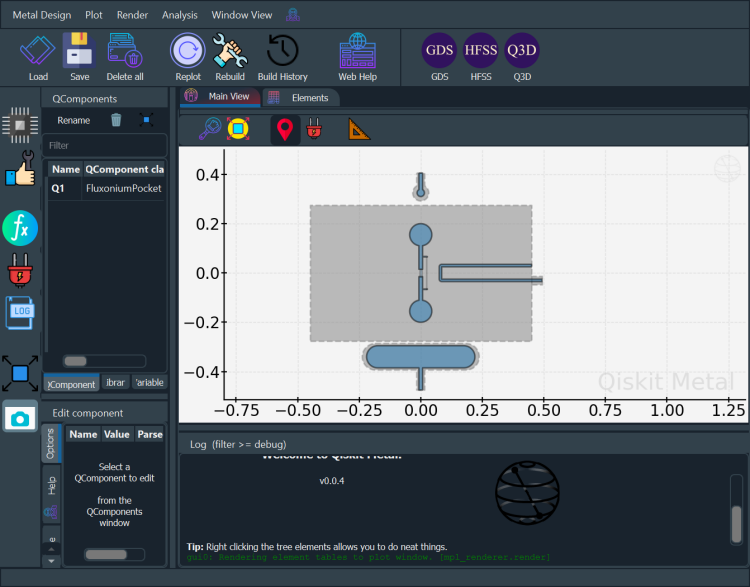

In [4]:
gui.screenshot()

## 2. 

In [9]:
eig_qb = EPRanalysis(design,"hfss")

In [10]:
eig_qb.sim.setup_update(n_modes = 3,
                        max_delta_f = 0.1,
                        min_freq_ghz = 1,
                        max_passes = 12)
eig_qb.sim.setup.vars.Lj = q1.options.L_j
eig_qb.sim.setup.vars.Ls = q1.options.l_inductance

eig_qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 3,
 'max_delta_f': 0.1,
 'max_passes': 12,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '34.38nH', 'Cj': '0 fF', 'Ls': '200nH'}}

In [11]:
eig_qb.sim.run(name="FluxoniumPocket", components=['Q1'], open_terminations=[], box_plus_buffer = False)

INFO 04:51PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:51PM [load_ansys_project]: 	Opened Ansys App
INFO 04:51PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 04:51PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project64
INFO 04:51PM [connect_design]: 	Opened active design
	Design:    FluxoniumEPR_hfss [Solution type: Eigenmode]
INFO 04:51PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:51PM [connect]: 	Connected to project "Project64" and design "FluxoniumEPR_hfss" 😀 

INFO 04:51PM [connect_design]: 	Opened active design
	Design:    FluxoniumPocket_hfss [Solution type: Eigenmode]
WARNING 04:51PM [connect_setup]: 	No design setup detected.
WARNING 04:51PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:51PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys

In [8]:
eig_qb.sim.convergence_f

,re(Mode(1)) [g],re(Mode(2)) [g],re(Mode(3)) [g]
Pass [],,,
1,1.451393,7.874313,14.665349
2,2.307252,9.470313,16.354230
3,4.483297,10.389748,16.853574
4,6.480017,10.752196,16.862188
5,8.719602,11.094570,16.863245
6,9.333765,11.217545,16.863288
7,9.460598,11.241472,16.863299
8,9.537934,11.259411,16.863312
9,9.625544,11.268690,16.863365


In [9]:
# Add the geometry of the rectangle  and line of the inductor to the list of junctions
eig_qb.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_qb.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'

eig_qb.add_junction(name_junction ='inductor')
eig_qb.setup.junctions.inductor.Lj_variable = 'Ls'
eig_qb.setup.junctions.inductor.rect = 'JJ_rect_Lj_Q1_inductor'
eig_qb.setup.junctions.inductor.line = 'JJ_Lj_Q1_inductor_'
# eig_qb.setup.junctions.inductor.is_junction = False

# Set up th EPR analysis parameters
eig_qb.setup.fock_trunc = 15
eig_qb.setup.flux = 0.5

# eig_qb.setup.sweep_variable = 'flux'   #--- This would be nice to implement to get a sweep over flux bias 
eig_qb.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'},
  'inductor': {'Lj_variable': 'Ls',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_inductor',
   'line': 'JJ_Lj_Q1_inductor_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 15,
 'sweep_variable': 'Lj',
 'flux': 0.5}

In [10]:
eig_qb.setup.junctions['jj']

{'Lj_variable': 'Lj',
 'Cj_variable': 'Cj',
 'rect': 'JJ_rect_Lj_Q1_rect_jj',
 'line': 'JJ_Lj_Q1_rect_jj_'}

In [11]:
eig_qb.run_epr()
#### equivalent individual calls
#s = eig_qb.setup
#eig_qb.epr_start()
#eig_qb.get_stored_energy()
#eig_qb.run_analysis()
#eig_qb.spectrum_analysis(['jj'],s.cos_trunc, s.fock_trunc)
#eig_qb.report_hamiltonian(s.sweep_variable)

Design "FluxoniumPocket_hfss" info:
	# eigenmodes    3
	# variations    1
Design "FluxoniumPocket_hfss" info:
	# eigenmodes    3
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.69482625983358e-25
        energy_elec_substrate = 1.55639240043045e-25
        EPR of substrate = 91.8%

        energy_mag    = 1.54551701979946e-27
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 9.73 GHz   [1/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  8.474e-26 7.728e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 89.11%
	jj              0.913915  (+)        0.111682


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 40.08%
	inductor        0.0750965  (+)        0.112256
		(U_tot_cap-U_tot_ind)/mean=10.16%
Calculating Qdielectric_main for mode 0 (0/2)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_0 = 0.9183197341910886

  Mode 1 at 11.29 GHz   [2/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.9%  2.473e-27 2.509e-30

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 85.88%
	jj              1.69813e-05  (+)        2.79271e-06


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 33.20%
	inductor        1.32911e-06  (+)        2.67379e-06
		(U_tot_cap-U_tot_ind)/mean=99.79%
Calculating Qdielectric_main for mode 1 (1/2)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_1 = 0.9177505531983497

  Mode 2 at 16.86 GHz   [3/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               -0.0%   1.78e-21  1.78e-21

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 73.15%
	jj              7.76927e-09  (+)        2.8522e-09


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 18.21%
	inductor        6.36878e-10  (+)        2.86001e-09
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 2 (2/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.2301330243191489


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:39PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 09:39PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 199.6% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project33\FluxoniumPocket_hfss\2022-09-29 21-39-05.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


ERROR 09:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 199.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0        1.227378
1    54503.345293
2       10.872908
dtype: float64

Pm_norm idx =
      jj  inductor
0   True     False
1  False     False
2  False     False
*** P (participation matrix, not normlz.)
             jj      inductor
0  7.467012e-01  6.135647e-02
1  1.698121e-05  1.329104e-06
2  7.769275e-09  6.368784e-10

*** S (sign-bit matrix)
   s_jj  s_inductor
0     1           1
1    -1          -1
2    -1          -1
*** P (participation matrix, normalized.)
      0.92    0.061
   1.7e-05  1.3e-06
   7.8e-09  6.4e-10

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  1.05e+03   0.0455 3.12e-05
    0.0455 4.94e-07 6.77e-10
  3.12e-05 6.77e-10 2.32e-13

*** Chi matrix ND (MHz) 
  1.71e+03   0.0219 2.05e-05
    0.0219 2.67e-08 2.02e-10
  2.05e-05 2.02e-10-6.48e-11

*** Frequencies O1 PT (MHz)
0     8680.732996
1    11286.846219
2    16863.423363
dtype: float64

*** Frequencies ND (MHz)
0     8515.742421
1    11286.854103
2    16863.4

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,16.35
0,8515.74
1,11286.85
2,16863.42


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2
Lj                                   
16.35 0  1.71e+03  2.19e-02  2.05e-05
      1  2.19e-02  2.67e-08  2.02e-10
      2  2.05e-05  2.02e-10 -6.48e-11

09:40PM 32s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


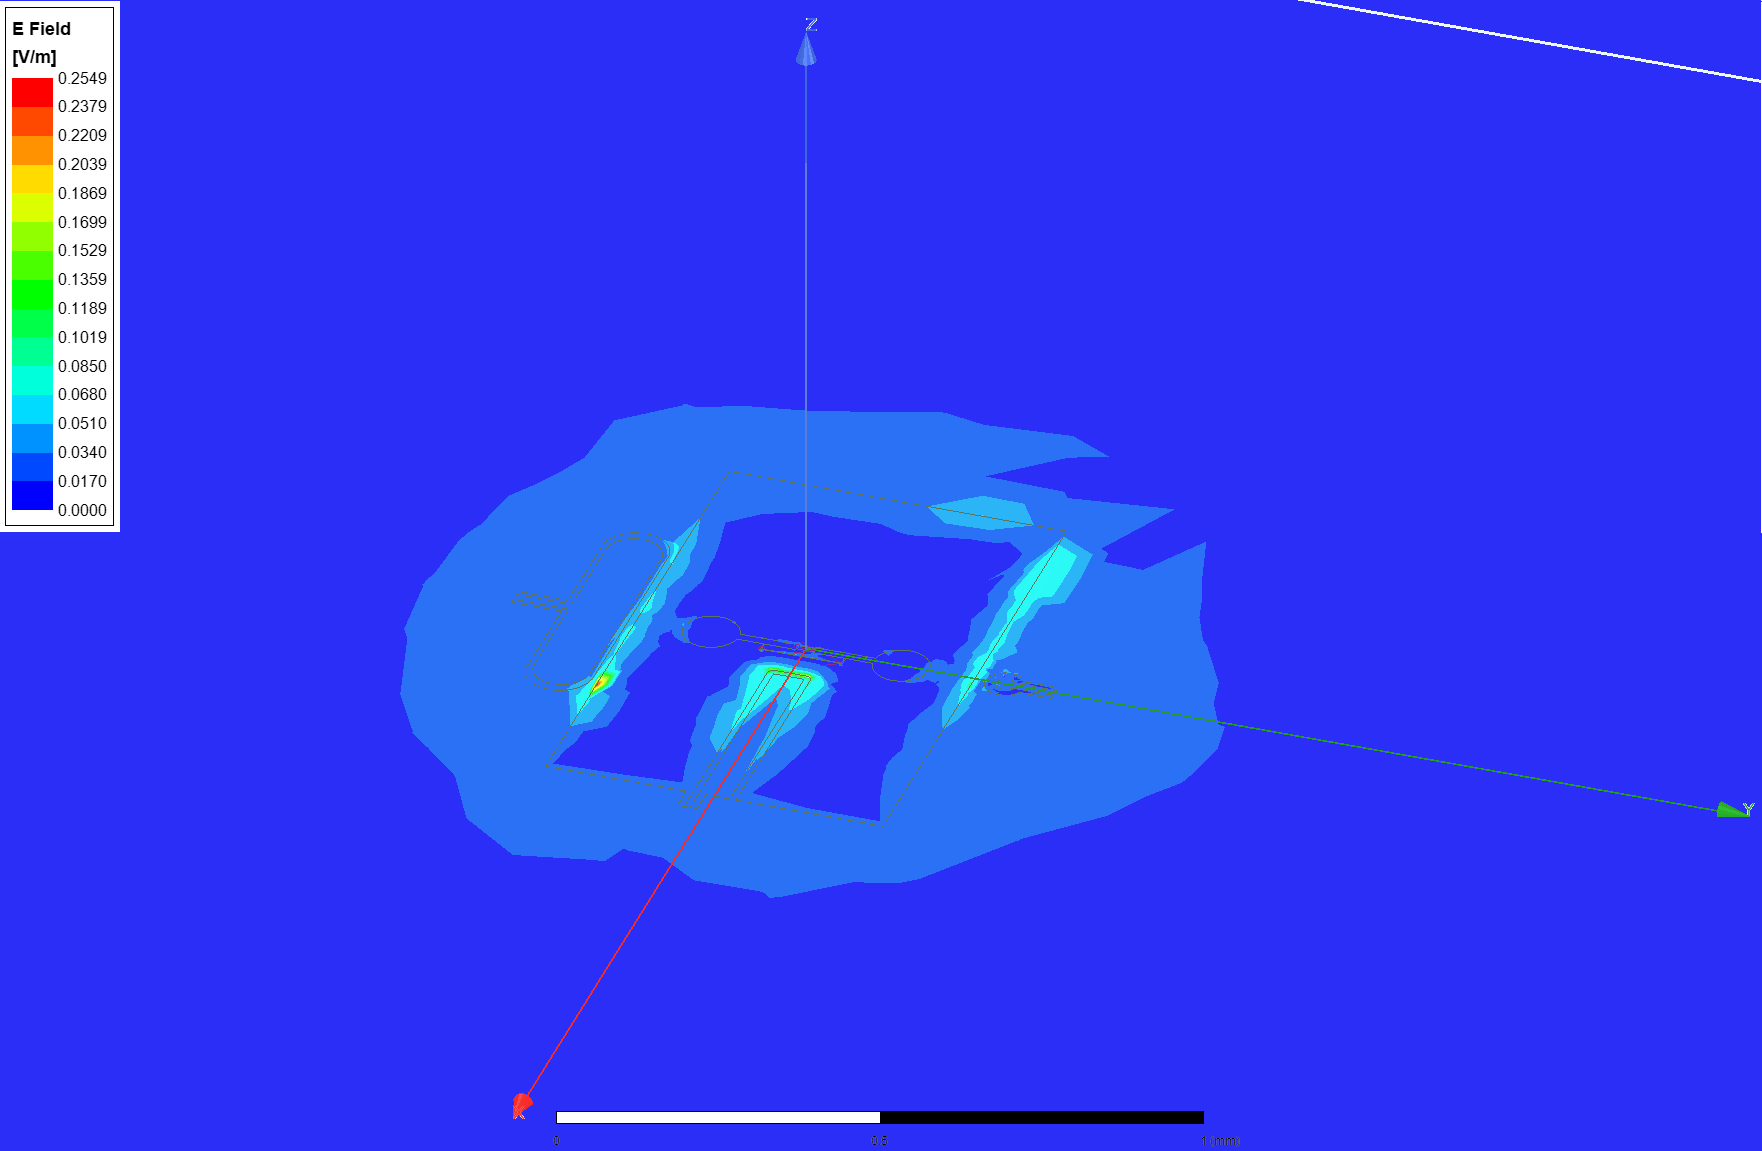

WindowsPath('C:/Users/figenyilmaz/Documents/GitLab/qiskit-metal/Fluxonium Designs/ansys.png')

In [12]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [13]:
hfss.epr_get_frequencies()

Design "FluxoniumPocket_hfss" info:
	# eigenmodes    3
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        9.729361             inf
          1       11.286869             inf
          2       16.863423             inf

In [14]:
hfss.plot_ansys_delete(['Mag_E1'])

09:40PM 40s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [15]:
hfss.set_mode(2, "Setup")

INFO 09:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


09:40PM 45s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


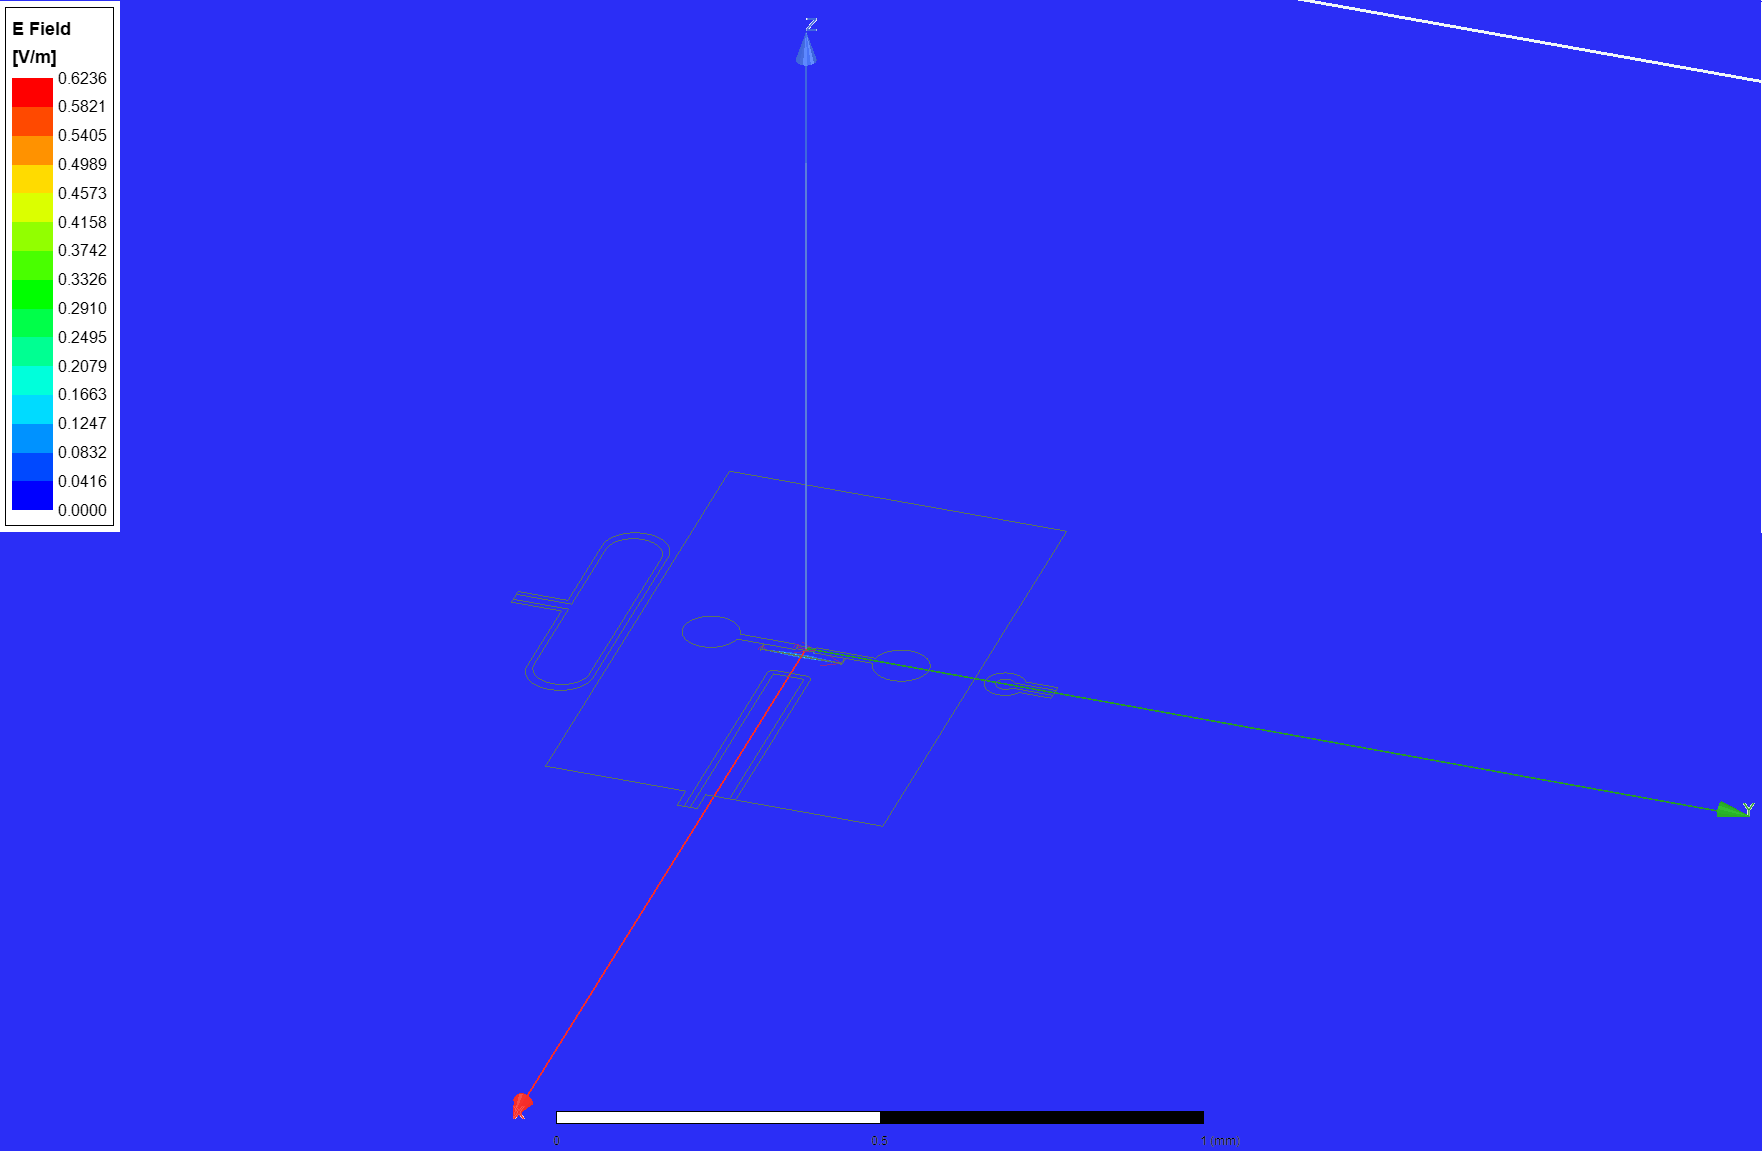

WindowsPath('C:/Users/figenyilmaz/Documents/GitLab/qiskit-metal/Fluxonium Designs/ansys.png')

In [16]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [17]:
hfss.plot_ansys_delete(['Mag_E1'])

09:40PM 58s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [18]:
hfss.set_mode(3, "Setup")

INFO 09:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


09:41PM 00s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


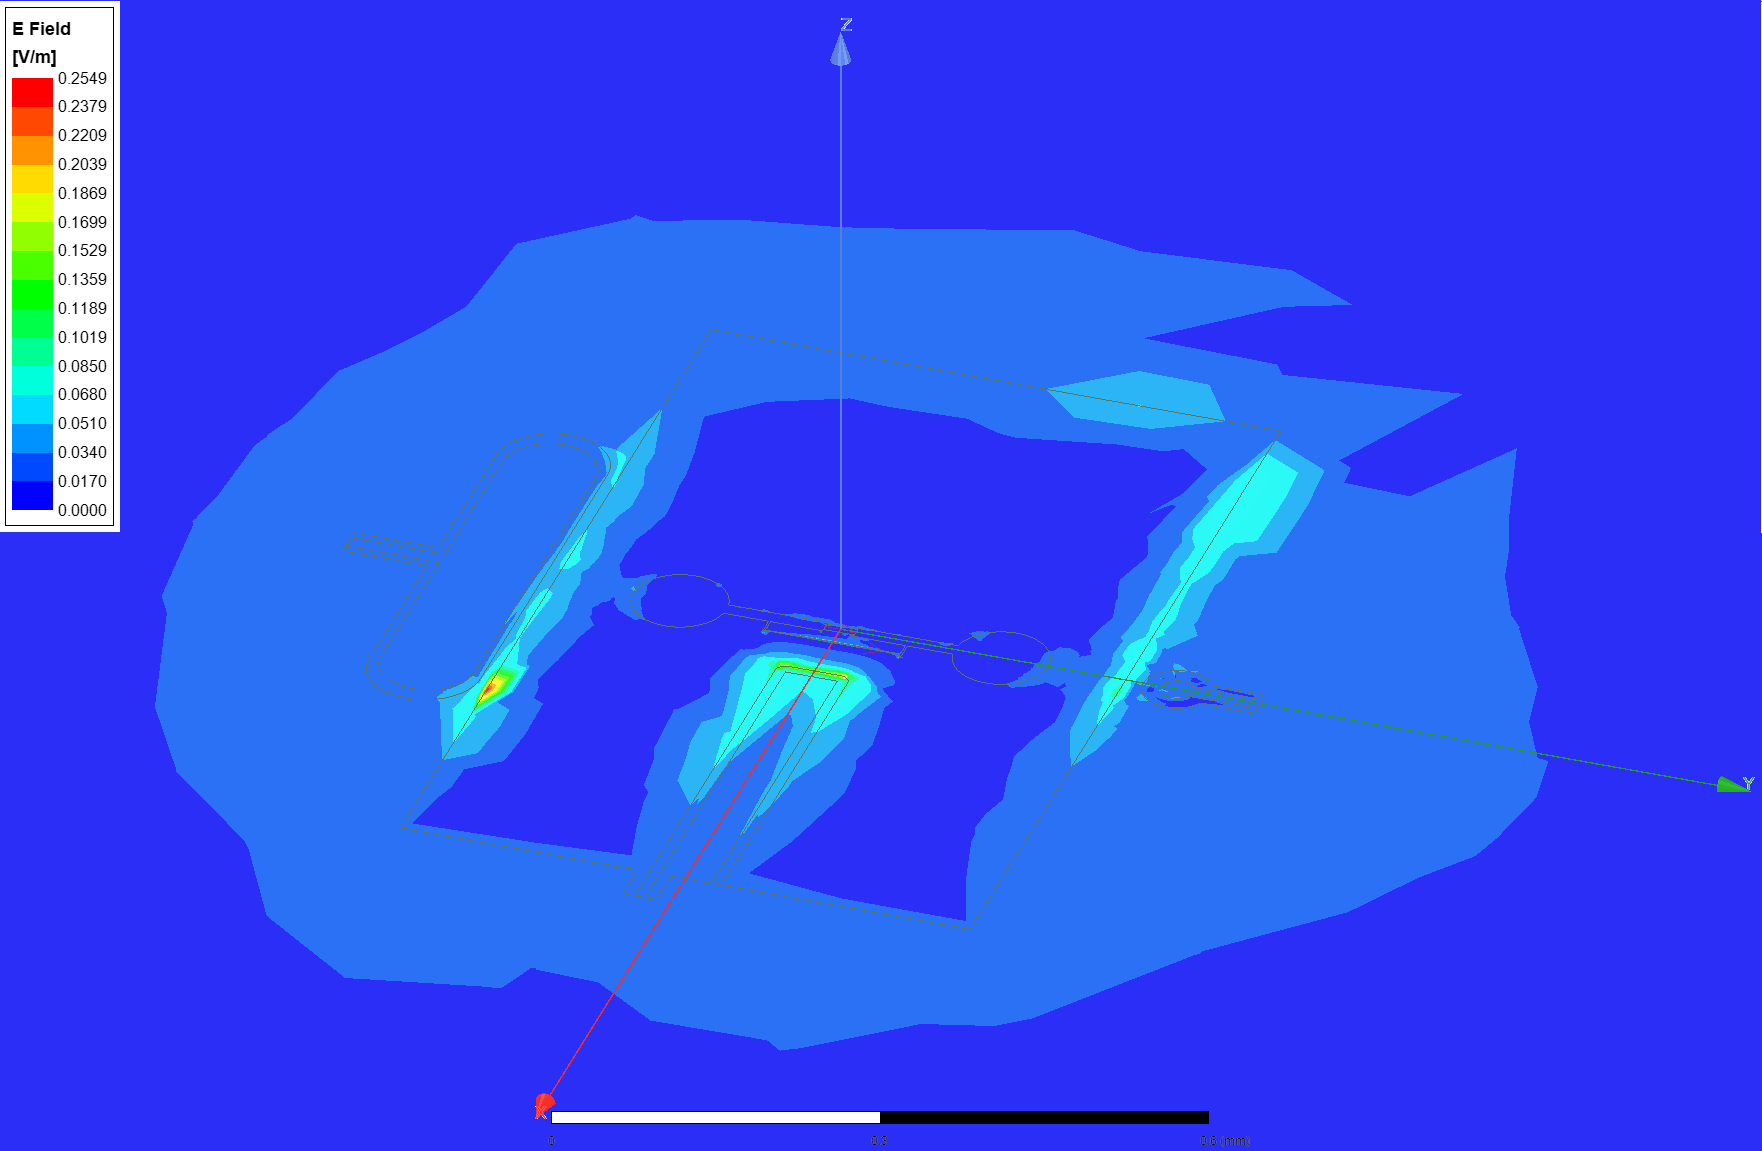

WindowsPath('C:/Users/figenyilmaz/Documents/GitLab/qiskit-metal/Fluxonium Designs/ansys.png')

In [19]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [30]:
hfss.plot_ansys_delete(['Mag_E1'])

01:32PM 05s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [32]:
gui.main_window.close()

True

In [33]:
hfss.disconnect_ansys()

01:34PM 53s WARNING [disconnect_ansys]: This renderer appears to be already disconnected from Ansys


## Here we design all chip, for that we need to add the open terminals from the lib

## Here we start EPR analysis for whole chip

In [20]:
eig_qb = EPRanalysis(design,"hfss")

In [21]:
eig_qb.sim.setup_update(n_modes = 2,
                        max_delta_f = 0.1,
                        min_freq_ghz = 1,
                        max_passes = 12)
eig_qb.sim.setup.vars.Lj = '32nH'
eig_qb.sim.setup.vars.Ls = q1.options.l_inductance

eig_qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.1,
 'max_passes': 12,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '32nH', 'Cj': '0 fF', 'Ls': '200nH'}}

In [22]:
eig_qb.sim.run(name="FluxoniumEPR", components=['Q1', 'cavity1', 'otg1s'], open_terminations=[], box_plus_buffer = False)

INFO 09:43PM [connect_design]: 	Opened active design
	Design:    FluxoniumEPR_hfss [Solution type: Eigenmode]
09:43PM 14s WARNING [get_unique_component_ids]: The component=otg1s in highlight_qcomponents not in QDesign.
09:43PM 14s WARNING [render_design]: Unable to proceed with rendering. Please check selection.
INFO 09:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:43PM [analyze]: Analyzing setup Setup


com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024349), None)

In [27]:
gui.main_window.close()

True